In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# load the data
data = pd.read_csv('../data/benchmark_features.csv')

print(data.shape)
display(data.head())


(1321, 61)


,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,normal,normal,normal,normal,normal,normal,normal,normal,abnormal,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal,1.0


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

# assign X and y
X, y = data.drop('dropout', axis=1), data['dropout']

# print shape
X.shape, y.shape

((1321, 60), (1321,))

## Split the Data

In [3]:
# split the data to traininig, validation and test sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# split the development set to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=0)

# print the shape for each dataset
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)


Training set: (844, 60) (844,)
Validation set: (212, 60) (212,)
Test set: (265, 60) (265,)


## Assign columns to dtype for pipelines

In [4]:
# start with int and float
int_columns = [col for col in X_train.columns if X_train[col].dtype == 'int64']
float_columns = [col for col in X_train.columns if X_train[col].dtype == 'float64']

# Combine both lists if you need columns of both types
numeric_columns = int_columns + float_columns

# get categorical columns
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

### Using C-Index as calssification metric

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import make_scorer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import helper

# Define the custom scoring function
def cindex_scorer(y_true, y_pred):
    return helper.cindex(y_true, y_pred)

# Create a scorer object
cindex = make_scorer(cindex_scorer, greater_is_better=True)

# Instantiate the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', IterativeImputer(max_iter=10, random_state=0)),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# Define the classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Define pipelines for each classifier
pipelines = {
    name: Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
    for name, classifier in classifiers.items()
}

# Define parameter grids for each classifier
param_grids = {
    'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
    'RandomForest': {'classifier__n_estimators': [200, 300, 400], 
                     'classifier__max_depth': [3, 5, 10]},
    'XGBoost': {'classifier__learning_rate': [0.01, 0.1, 0.3],
                'classifier__n_estimators': [200, 300, 400]}
}


# Initialize results storage
results = []

# Run GridSearchCV for each pipeline
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring=cindex, return_train_score=True)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    
    train_accuracy = helper.cindex(y_train, y_train_pred)
    val_accuracy = helper.cindex(y_val, y_val_pred)
    
    print(f"{name} - Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    results.append({
        'model': name,
        'train_accuracy': train_accuracy,
        'validation_accuracy': val_accuracy,
        'best_params': grid_search.best_params_
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the best parameters for each model
for index, row in results_df.iterrows():
    print()
    print(f"Model: {row['model']}")
    print()
    print(f"Best Parameters: {row['best_params']}")
    print()


Training LogisticRegression...
LogisticRegression - Train Accuracy: 0.7703, Validation Accuracy: 0.7258
Training RandomForest...
RandomForest - Train Accuracy: 0.9812, Validation Accuracy: 0.8392
Training XGBoost...
XGBoost - Train Accuracy: 0.9435, Validation Accuracy: 0.8334

Model: LogisticRegression

Best Parameters: {'classifier__C': 0.1}


Model: RandomForest

Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 400}


Model: XGBoost

Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 300}



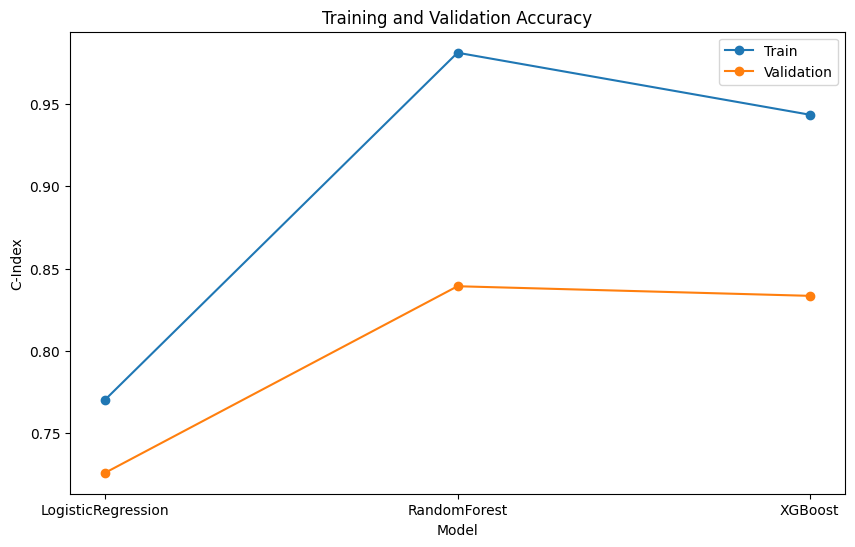

In [6]:
# Convert DataFrame columns to numpy arrays
models = results_df['model'].values
train_accuracy = results_df['train_accuracy'].values
validation_accuracy = results_df['validation_accuracy'].values

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(models, train_accuracy, marker='o', label='Train')
plt.plot(models, validation_accuracy, marker='o', label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('C-Index')
plt.legend()
plt.show()